In [1]:
using JuMP, Ipopt, CSV, DataFrames, CairoMakie, Statistics

In [2]:
# --------------------------------------------
# MPC controller to minimize electricity cost
# with global energy target enforcement
# --------------------------------------------

# ---------- Load electricity prices ----------
predicted_df = CSV.read("data/PredictedPrices.csv", DataFrame; header=false)
cEl = predicted_df[:, 1]  # this gives you a vector of 168 predicted prices
horizon = length(cEl)

# ---------- Parameters ----------
N = 10                  # MPC prediction horizon
#N = 15                  # MPC prediction horizon
#N = 3                  # MPC prediction horizon

P_min = 0.5
P_max = 1.5
P_nom = 1.0
Delta_max = 0.5
S_max = 5.0
zeta = 0.2

# ---------- Nonlinear efficiency function ----------
function P_eff_fun(p, zeta)
    return p * (1 - zeta * ((P_nom - p)/0.5)^2)
end

# ---------- Initialize simulation storage ----------
P_applied = zeros(horizon)
S = zeros(horizon + 1)  # storage level, S[1] = 0

# ---------- MPC Loop ----------
for t in 1:horizon
    N_step = min(N, horizon - t + 1)  # shrink prediction horizon near end

    # Energy tracking
    E_target = horizon * P_nom
    E_actual = sum(P_applied[1:t-1])
    steps_remaining = horizon - t + 1
    E_rem_avg = (E_target - E_actual) / steps_remaining * N_step

    # Create optimization model
    model= Model(Ipopt.Optimizer)
    set_silent(model)

    @variable(model, P_min <= P[1:N_step] <= P_max)
    @variable(model, S_var[1:N_step+1])

    # Initial conditions
    @constraint(model, S_var[1] == S[t])

    # Ramp rate constraints (skip for t = 1)
    if t > 1
        P_prev = P_applied[t-1]
        @constraint(model, -Delta_max <= P[1] - P_prev <= Delta_max)
    end
    @constraint(model, [k=2:N_step], -Delta_max <= P[k] - P[k-1] <= Delta_max)

    # Storage dynamics using nonlinear P_eff directly
    @NLconstraint(model, [k=1:N_step],
        S_var[k+1] == S_var[k] + (P[k] * (1 - zeta * ((P_nom - P[k])/0.5)^2) - P_nom))

    # Storage bounds
    @constraint(model, [k=1:N_step+1], -S_max <= S_var[k] <= S_max)

    # Global energy consistency constraint
    @NLconstraint(model,
        sum(P[k] * (1 - zeta * ((P_nom - P[k])/0.5)^2) for k in 1:N_step) >= E_rem_avg)

    # Objective: minimize cost over prediction horizon
    @NLobjective(model, Min, sum(cEl[t + k - 1] * P[k] for k=1:N_step))

    # Set initial guesses to help Ipopt converge
    for k in 1:N_step
        set_start_value(P[k], P_nom)
    end
    for k in 1:(N_step+1)
        set_start_value(S_var[k], S[t])
    end

    optimize!(model)

    # Apply first control action if solution is usable
    if termination_status(model) in [MOI.OPTIMAL, MOI.LOCALLY_SOLVED]
        P_next = value(P[1])
        P_applied[t] = P_next
        S[t+1] = S[t] + P_eff_fun(P_next, zeta) - P_nom
    else
        println("MPC failed at step $t → Termination: ", termination_status(model))
        break
    end
end

# ---------- Results ----------
println("\nApplied power over horizon:")
println(P_applied)
println("\nStorage level over time:")
println(S) # S[1] to S[horizon+1]


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************


Applied power over horizon:
[1.1364352454758313, 1.1384110690987674, 1.1177535601875541, 1.070730190108881, 0.9910813194675857, 0.898830966820453, 0.8735561752935637, 0.8938267457087502, 0.969263416891834, 1.0523038174941097, 1.1149628979174717, 1.1556879483309899, 1.1668532658787096, 1.1489760950211612, 1.1106931950376677, 1.047619495188625, 0.9753575803452684, 0.8999959185377012, 0.7902234575864397, 0.7642922285732386, 0.8503846680741072, 0.9459533724479956, 1.0509665054953288, 1.0954446098752422, 1.1366200708777952, 1.1312319952035514, 1.097486279067435, 1.0623381527174962, 1.000073076664135, 0.9333472

In [3]:
# ---------- Energy deviation summary ----------
total_P = sum(P_applied)
delta_energy = total_P - horizon * P_nom
println("\nDifference between total applied power and nominal energy:")
println("Δ = $(round(delta_energy, digits=4)) MWh")


Difference between total applied power and nominal energy:
Δ = 0.0158 MWh


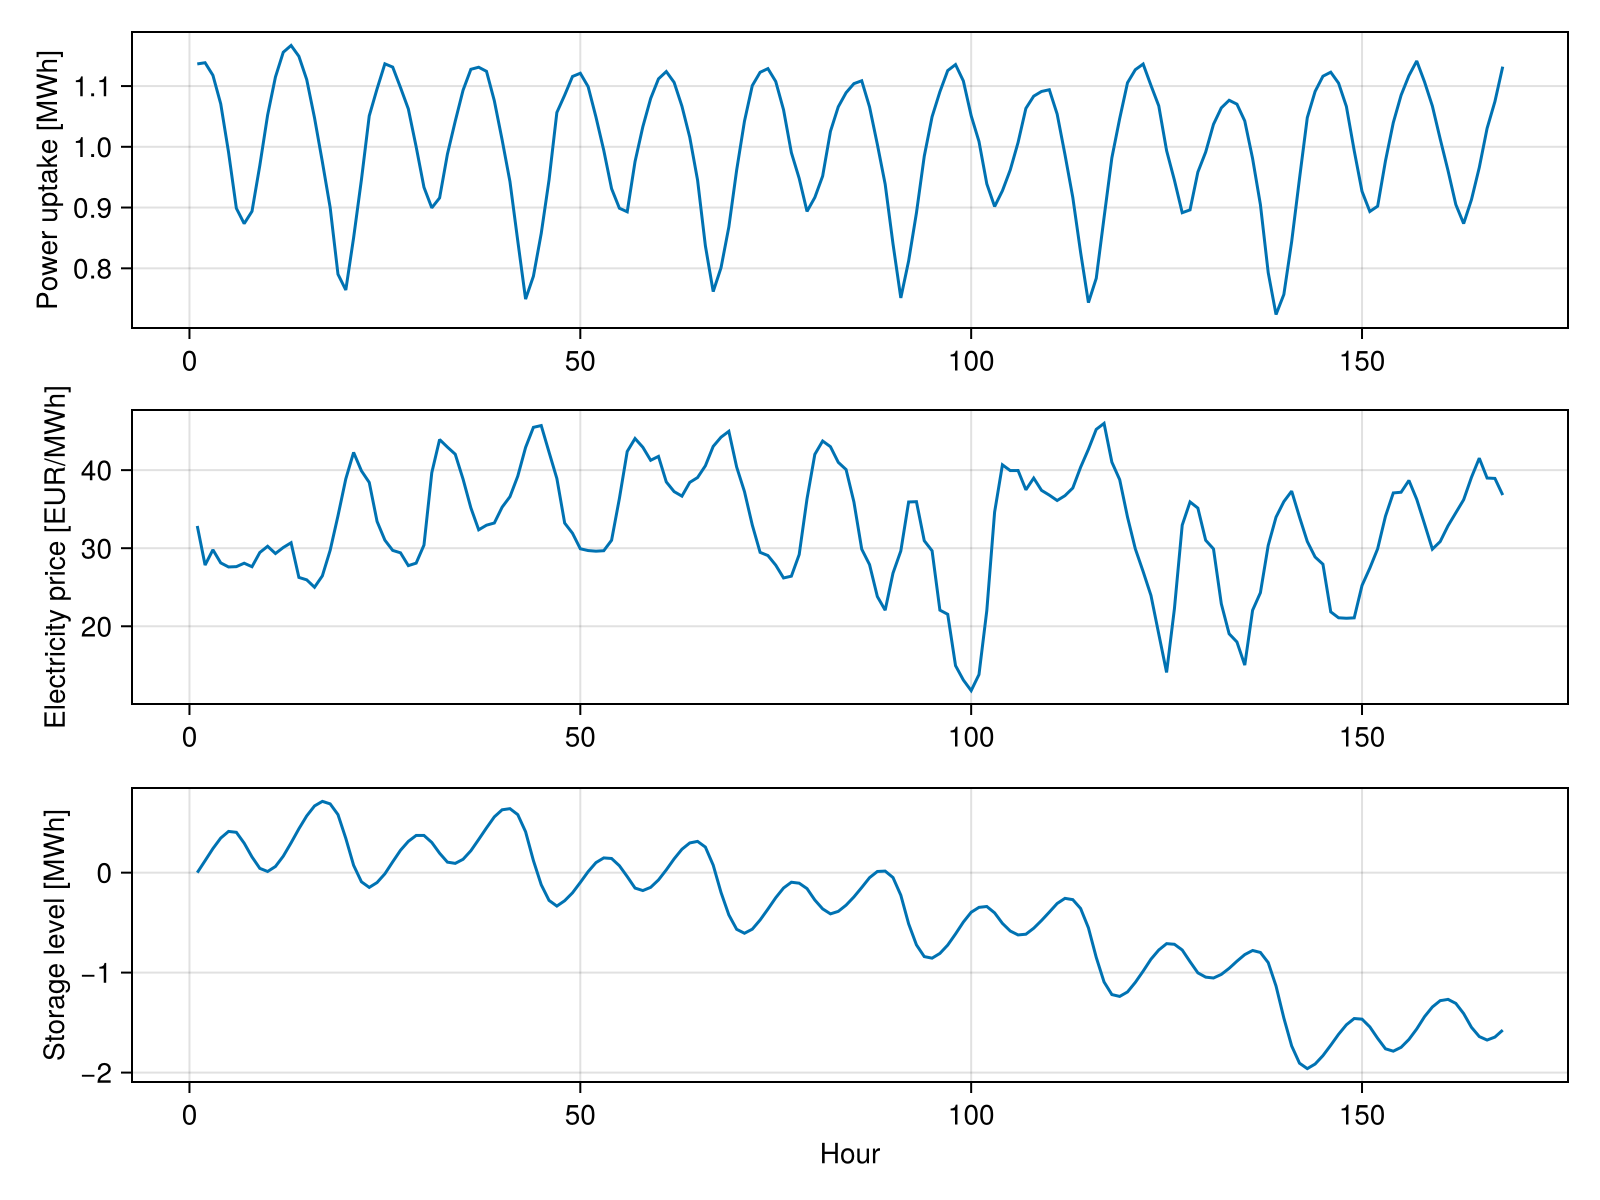

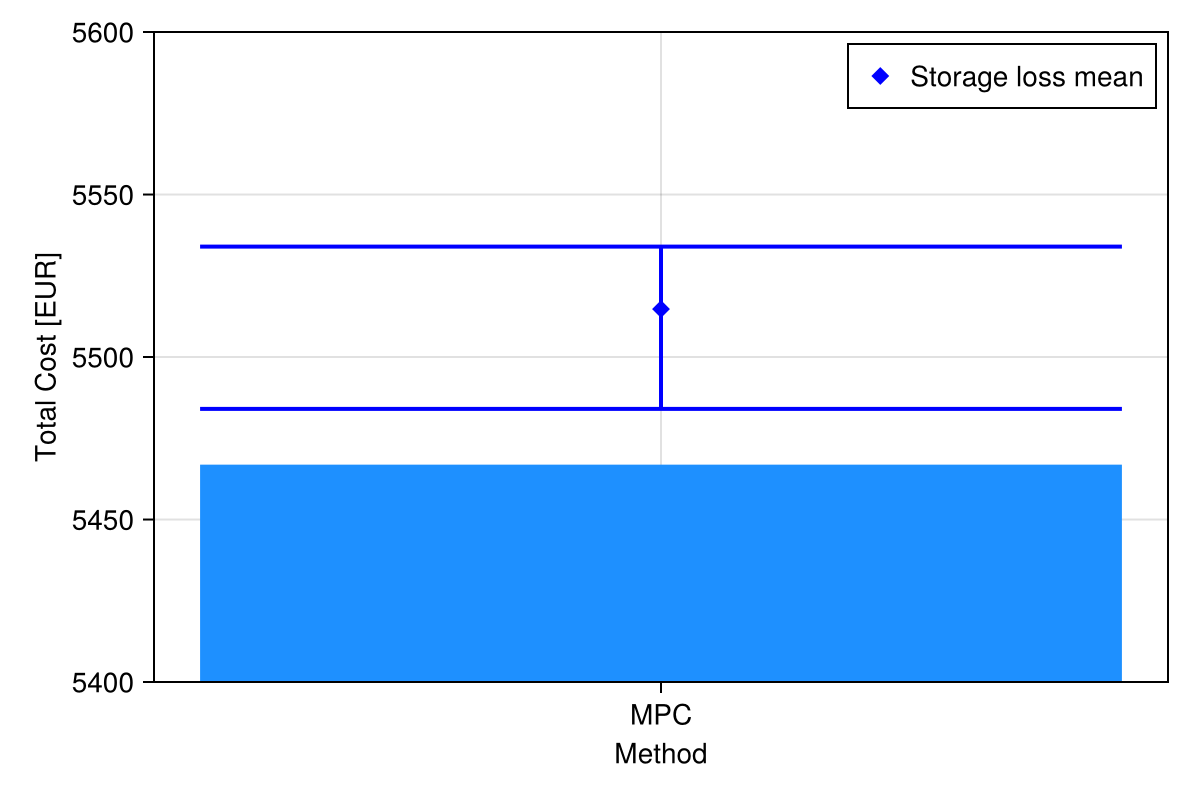

CairoMakie.Screen{IMAGE}


In [4]:
# ---------- Load actual electricity prices from column "2017" ----------
df = CSV.read("data/DayAheadSpotPrices.csv", DataFrame)
real_prices = df[!, "2017"] |> skipmissing |> collect
start = 5880
horizon = 168
cEl_real = real_prices[start:start + horizon - 1]  # real prices for plotting and cost

# ---------- Plot 1: Time-series of MPC behavior ----------
power = P_applied
storages = S[1:end-1]

fig1 = Figure(size = (800, 600))
ax1 = Axis(fig1[1, 1], ylabel="Power uptake [MWh]")
ax2 = Axis(fig1[2, 1], ylabel="Electricity price [EUR/MWh]")
ax3 = Axis(fig1[3, 1], ylabel="Storage level [MWh]", xlabel="Hour")

lines!(ax1, 1:horizon, power)
lines!(ax2, 1:horizon, cEl_real)
lines!(ax3, 1:horizon, storages)

save("Images/mpc_behavior.png", fig1; px_per_unit = 6.0)
display(fig1)

# ---------- Plot 2: Bar plot with cost + storage loss penalty ----------
total_cost_mpc = sum(P_applied .* cEl_real)
final_storage = S[end]

price_max = maximum(cEl_real)
price_min = minimum(cEl_real)
price_avg = mean(cEl_real)

# Always assume storage deviation must be "recovered" at cost
box_max = total_cost_mpc + abs(final_storage) * price_max
box_min = total_cost_mpc + abs(final_storage) * price_min
box_mean = total_cost_mpc + abs(final_storage) * price_avg


methods = ["MPC"]
costs = [total_cost_mpc]
positions = 1:length(methods)

fig2 = Figure(size = (600, 400))

yticks_min = floor(min(box_min, total_cost_mpc) / 100) * 100
yticks_max = ceil(max(box_max, total_cost_mpc) / 100) * 100
yticks_step = 50

ax = Axis(fig2[1, 1];
    ylabel="Total Cost [EUR]",
    xlabel="Method",
    xticks=(positions, methods),
    yticks=yticks_min:yticks_step:yticks_max,
    limits=(nothing, (yticks_min, yticks_max))
)

barplot!(ax, positions, costs; width=0.5, color=:dodgerblue)

x = positions[1]
cap_width = 0.4

lines!(ax, [x, x], [box_min, box_max]; color=:blue, linewidth=2)
lines!(ax, [x - cap_width/2, x + cap_width/2], [box_min, box_min]; color=:blue, linewidth=2)
lines!(ax, [x - cap_width/2, x + cap_width/2], [box_max, box_max]; color=:blue, linewidth=2)

scatter!(ax, [x], [box_mean]; color=:blue, marker=:diamond, markersize=10, label="Storage loss mean")

axislegend(ax)
save("Images/mpc_cost_bar.png", fig2; px_per_unit=6.0)
display(fig2)


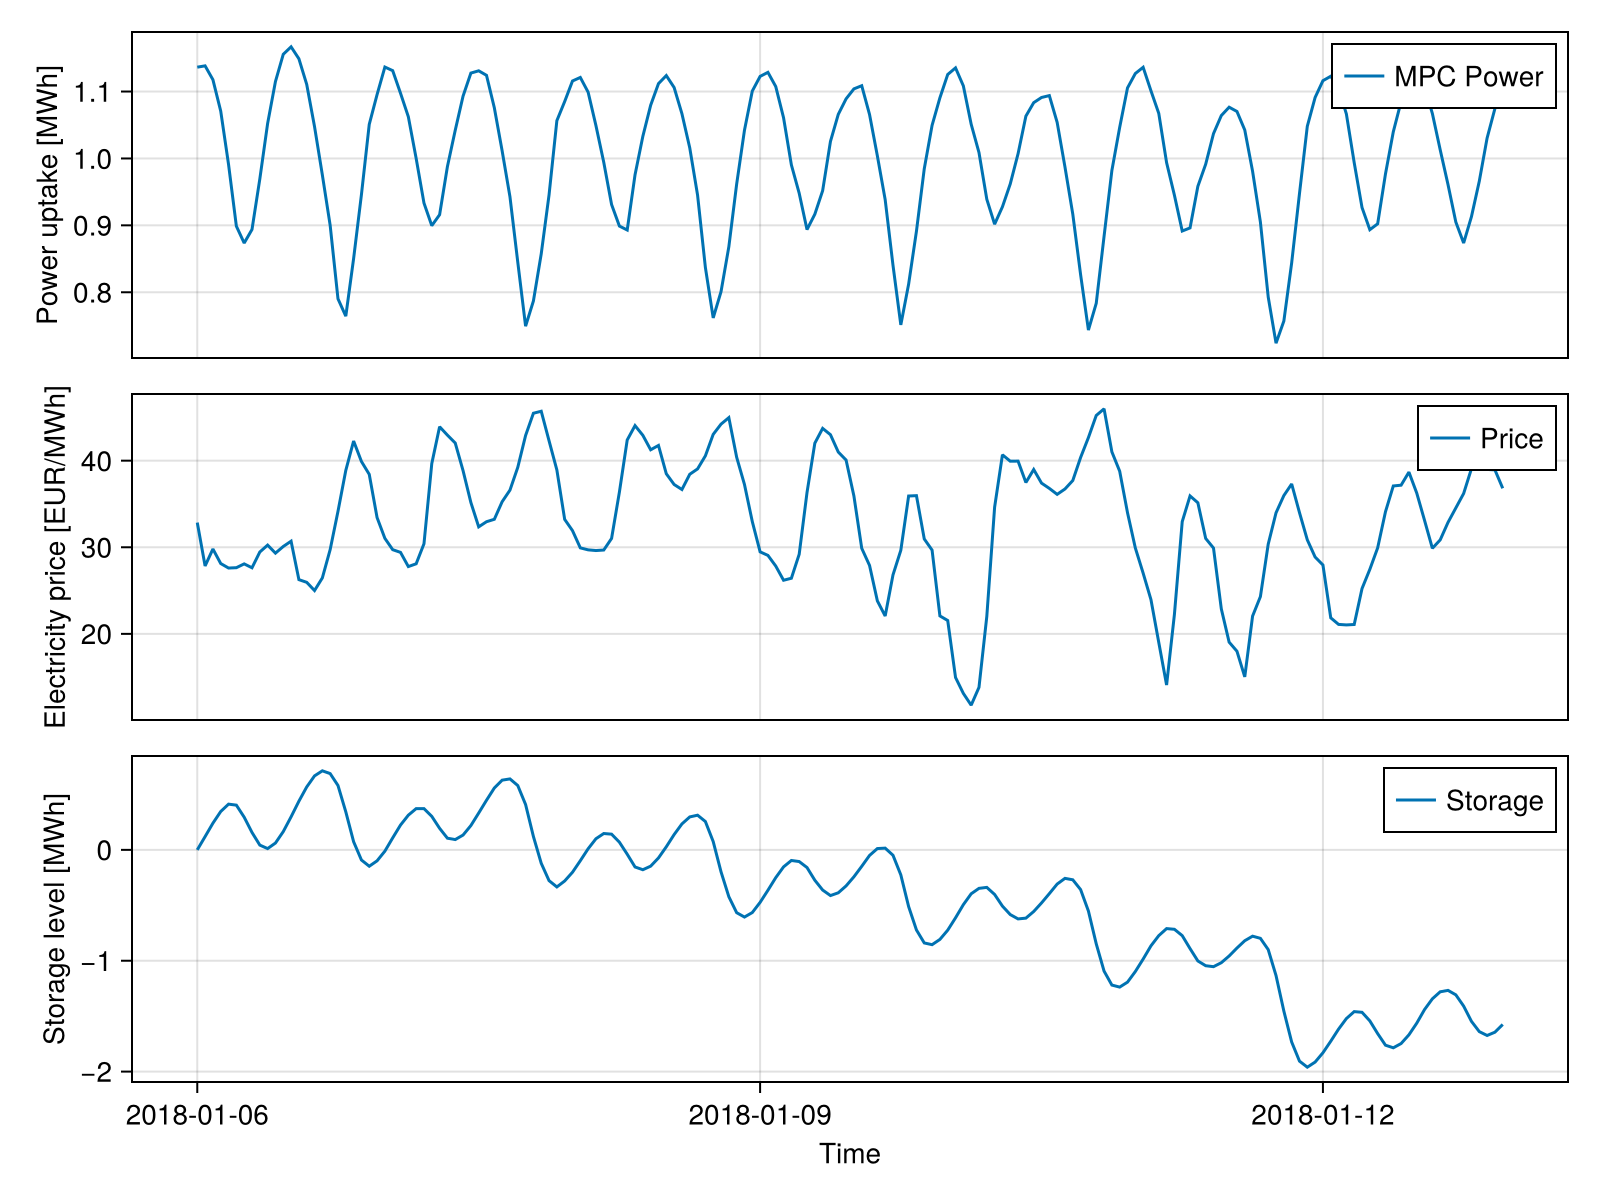

In [5]:
using CairoMakie
using Statistics
using CSV, DataFrames
using Dates

# ---------- Load actual electricity prices from column "2017" ----------
df = CSV.read("data/DayAheadSpotPrices.csv", DataFrame)
real_prices = df[!, "2017"] |> skipmissing |> collect

start = 5880
horizon = 168
cEl_real = real_prices[start:start + horizon - 1]

# ---------- Prepare datetime axis ----------
base_datetime = DateTime(2018, 1, 6)  # Set your desired starting datetime
hours = base_datetime .+ Hour.(0:horizon-1)  # Create correct datetime x-axis

# ---------- Data from MPC ----------
power = P_applied
storages = S[1:end-1]

# ---------- Plot ----------
fig1 = Figure(size = (800, 600))
ax1 = Axis(fig1[1, 1], ylabel="Power uptake [MWh]")
ax2 = Axis(fig1[2, 1], ylabel="Electricity price [EUR/MWh]")
ax3 = Axis(fig1[3, 1], ylabel="Storage level [MWh]", xlabel="Time")

lines!(ax1, hours, power, label="MPC Power")
lines!(ax2, hours, cEl_real, label="Price")
lines!(ax3, hours, storages, label="Storage")

hidexdecorations!(ax1, grid=false)
hidexdecorations!(ax2, grid=false)

axislegend(ax1)
axislegend(ax2)
axislegend(ax3)

save("Images/mpc_behavior_datetime.png", fig1; px_per_unit = 6.0)
fig1


In [6]:
using DelimitedFiles

# Save applied power and storage level
writedlm("data/P_mpc.csv", P_applied, ',')
writedlm("data/S_mpc.csv", S, ',')
